# 1. Import libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and pre-process the dataset

In [4]:
data_dir ='data'
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data\Training
Testing directory: data\Testing


In [5]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

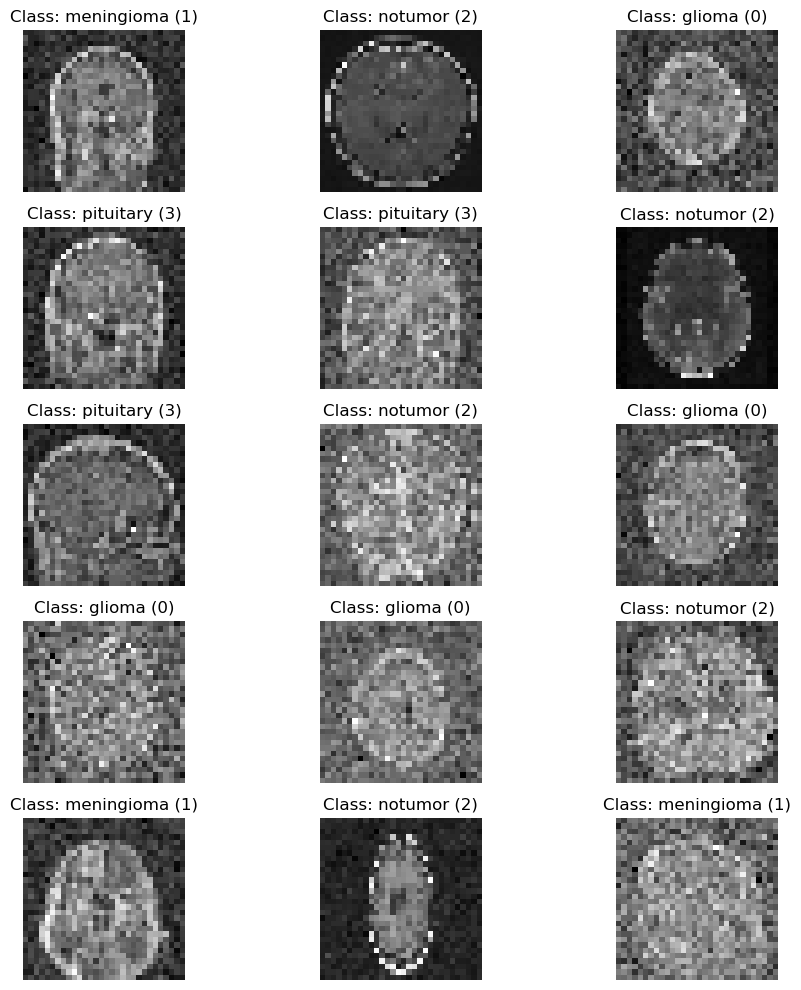

In [7]:
def visualize_batch(df): 

    #Iterating through the different batches
    image_batch, label_batch = next(df)

    #Deriving the class names
    class_names = train_data.class_indices

    #Creating 1 figure with 15 subplots
    fig, ax = plt.subplots(nrows= 5, ncols = 3, figsize = (10, 10))

    #Flatten the axis allowing for easier assignment of 'i'
    ax = ax.flatten()
    for i in range(15): 
        
        #For every ax[i], display the image on the index
        ax[i].imshow(image_batch[i], cmap = 'gray')
        ax[i].axis('off')
        
        #Deriving the class number and class name
        class_number = label_batch[i].argmax()
        
        #Displaying the class name and its corresponding number
        for name, number in class_names.items(): 
            
            #Checking which number corresponds to the class number
            if number == class_number: 
                class_name = name
                ax[i].set_title(f'Class: {class_name} ({class_number})')

    plt.tight_layout()
    plt.show()
    
visualize_batch(train_data)


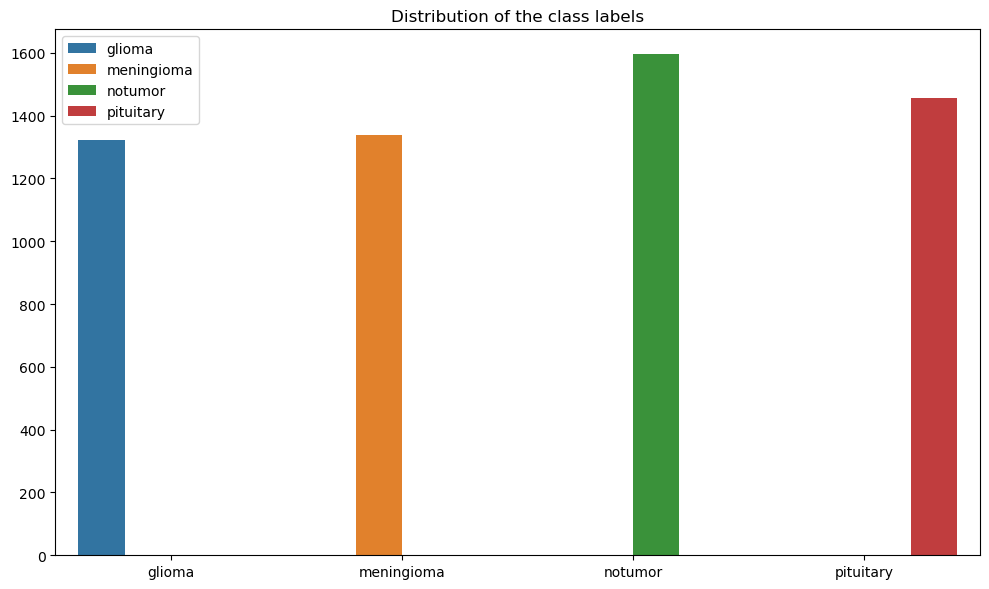

In [8]:
def plot_distribution(df):
    #Resetting the generator for consistent results
    df.reset()
    
    #Deriving the number of batches and classes
    n_batches = df.num_batches
    n_classes = df.num_classes
    class_names = list(df.class_indices.keys())
    total_samples = df.samples
    
    
    #Setting an emtpy array. Here the count of classes will be stored
    classes = np.zeros((1, n_classes))

    #Iterating over the batches and summing them, adding them to the np.zeros classes document 
    for i in range(n_batches): 
        x, y = next(df)
        sum_y = np.sum(y, axis = 0)
        classes += sum_y
    
    #Flattening the data so they can be plotted
    classes = classes.astype(int).flatten()
    
    #Testing if the sum of the classes aligns with the total samples in the train set.
    #If this it does not align, we made a mistake in coding
    assert np.sum(classes) == total_samples, 'The sum of classes does not allign with the total coding samples in the train set'
    
    plt.figure(figsize = (10, 6))
    sns.barplot(x = class_names, y = classes, estimator = np.sum, hue = class_names)
    plt.title('Distribution of the class labels')
    plt.tight_layout()
    plt.show()
    
        
plot_distribution(train_data)


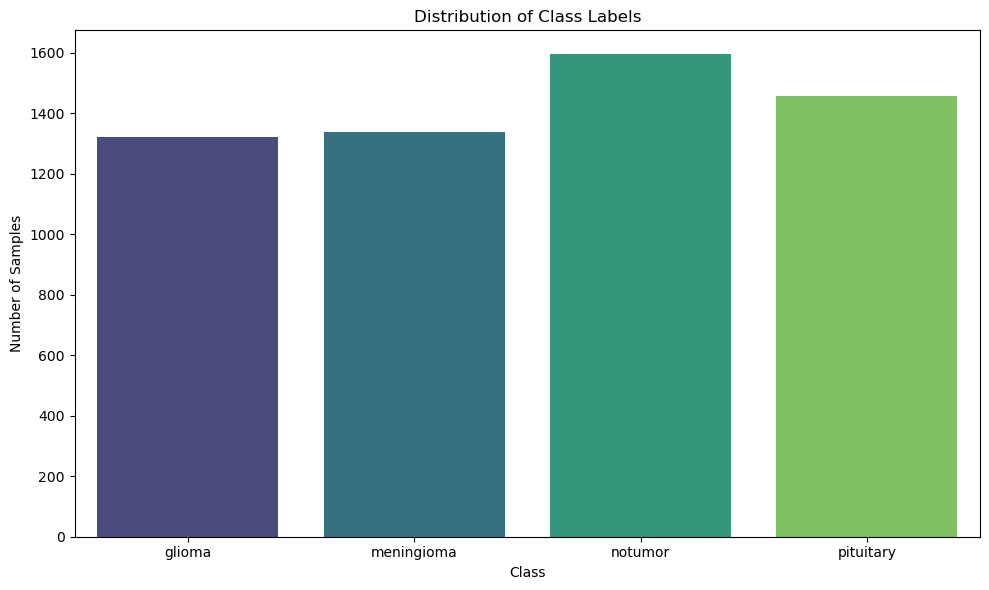

In [9]:
def plot_distribution(df):
    # Resetting the generator for consistent results
    df.reset()
    
    # Deriving the number of batches and classes
    n_batches = df.samples // df.batch_size + 1  # Calculating number of batches
    n_classes = df.num_classes
    class_names = list(df.class_indices.keys())
    total_samples = df.samples
    
    # Setting an empty array to store the class counts
    classes = np.zeros((n_classes,))
    
    # Iterating over the batches and summing the class labels
    for _ in range(n_batches): 
        x, y = next(df)
        sum_y = np.sum(y, axis=0)
        classes += sum_y
    
    # Flattening the data so it can be plotted
    classes = classes.astype(int).flatten()
    
    # Testing if the sum of the classes aligns with the total samples in the train set.
    assert np.sum(classes) == total_samples, 'The sum of classes does not align with the total samples in the dataset.'
    
    # Plotting the distribution of the classes
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=classes, estimator=np.sum, palette='viridis')
    plt.title('Distribution of Class Labels')
    plt.ylabel('Number of Samples')
    plt.xlabel('Class')
    plt.tight_layout()
    plt.show()

# Call the function to plot the distribution
plot_distribution(train_data)


# 4. Train and Evaluation functions

In [11]:
def train_val_split(df,val_split = 0.2): 
    #Resetting the generator for reproducible results
    df.reset()
    
    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples
    
    print(f'Number of batches in the training data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the training dataset {n_samples}')
    print()
    
    #Setting the size of the train and validation set according to the required split and testing if all batches are included
    val_batches = int(n_batches * val_split)
    train_batches = n_batches - val_batches
    
    print(f'Number of training data batches with val split of {val_split}: {train_batches}')
    print(f'Number of validation data batches: {val_batches}')
    print()
    assert train_batches + val_batches == n_batches, 'Train and val batches do not add up to total n batches'

    
    
    
    #Iterating through the batches and appending them into lists for train and val 
    x_train, y_train = list(), list()
    x_val, y_val = list(), list()
    
    for batch in range(n_batches): 
        x, y = next(df)
        if batch < train_batches: 
            x_train.append(x)
            y_train.append(y)
            
        else: 
            x_val.append(x)
            y_val.append(y)
        
    assert len(x_train) + len(x_val) == n_batches, 'Error in dividing batches into train and val sets'


    #Converting the lists into arrays suited for Tensorflow
    x_train = tf.concat(x_train, axis = 0)
    y_train = tf.concat(y_train, axis = 0)
    x_val = tf.concat(x_val, axis = 0)
    y_val = tf.concat(y_val, axis = 0)
    
    print(f'Shape of image training set: {x_train.shape}')
    print(f'Shape of image validation set: {x_val.shape}')
    print()
    print(f'Shape of label training set: {y_train.shape}')
    print(f'Shape of label validation set: {y_val.shape}')
    
    #Testing to see if all the samples are included
    assert x_train.shape[0] + x_val.shape[0] == n_samples, 'Error, not all samples included'
    
    
    
    return x_train, y_train, x_val, y_val
    
X_train, y_train, X_val, y_val = train_val_split(train_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)


In [12]:
from keras import Sequential, Input, layers
def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam", 
                    loss = "categorical_crossentropy",
                    metrics = ["accuracy"])
    return baseline

In [13]:
base = baseline()
base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4248 - loss: 1.2044 - val_accuracy: 0.7210 - val_loss: 0.7692
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7152 - loss: 0.7304 - val_accuracy: 0.7246 - val_loss: 0.6908
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7499 - loss: 0.6432 - val_accuracy: 0.7781 - val_loss: 0.5772
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7831 - loss: 0.5856 - val_accuracy: 0.7862 - val_loss: 0.5588
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 0.5280 - val_accuracy: 0.7908 - val_loss: 0.5588
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8040 - loss: 0.4998 - val_accuracy: 0.7563 - val_loss: 0.6244
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8256 - loss: 0.4766 - val_accuracy: 0.8007 - val_loss: 0.5325
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8184 - loss: 0.4628 - val_accuracy: 0.

In [14]:
# plot diagnostic learning curves
def summarize_loss(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(range(1,len(history.history['loss']) + 1),history.history['loss'], color='red', label='Train loss')
    plt.plot(range(1,len(history.history['val_loss']) + 1),history.history['val_loss'], color='green', label='Validation loss')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, which='both', linestyle='-')
    val_loss = history.history['val_loss']
    best_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(best_epoch, val_loss[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()
    return

def summarize_accuracy(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], color='red', label='Train accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], color='green', label='Validation accuracy')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, which='both', linestyle='-')
    val_accuracy = history.history['val_accuracy']
    best_epoch = val_accuracy.index(max(val_accuracy)) + 1
    plt.scatter(best_epoch, val_accuracy[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.show()
    return

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


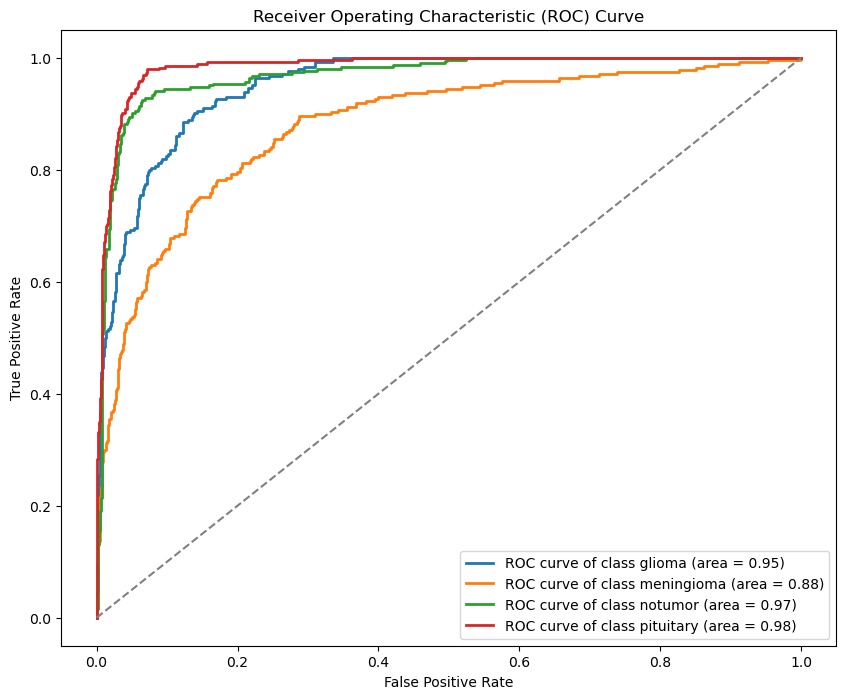

ROC AUC Scores: {0: 0.951453488372093, 1: 0.8785682565059063, 2: 0.9688281249999999, 3: 0.9837698975840785}


In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve_val(model, X_val, y_val, class_names):
    """
    Plots the ROC curve for the validation set without the macro-average.

    Parameters:
    - model: Trained model used to predict the validation set.
    - X_val: Validation feature data.
    - y_val: True labels for the validation set.
    - class_names: List of class names for labeling the ROC curve plot.
    """
    
    # Get model predictions for the validation set
    y_pred = model.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    
    # Binarize the output for multi-class ROC curve
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_pred_bin = y_pred
    
    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(class_name, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()
    
    return roc_auc

# Assuming `train_data.class_indices` gives you the class names
class_names = list(train_data.class_indices.keys())  
roc_auc_val = plot_roc_curve_val(base, X_val, y_val, class_names)
print("ROC AUC Scores:", roc_auc)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

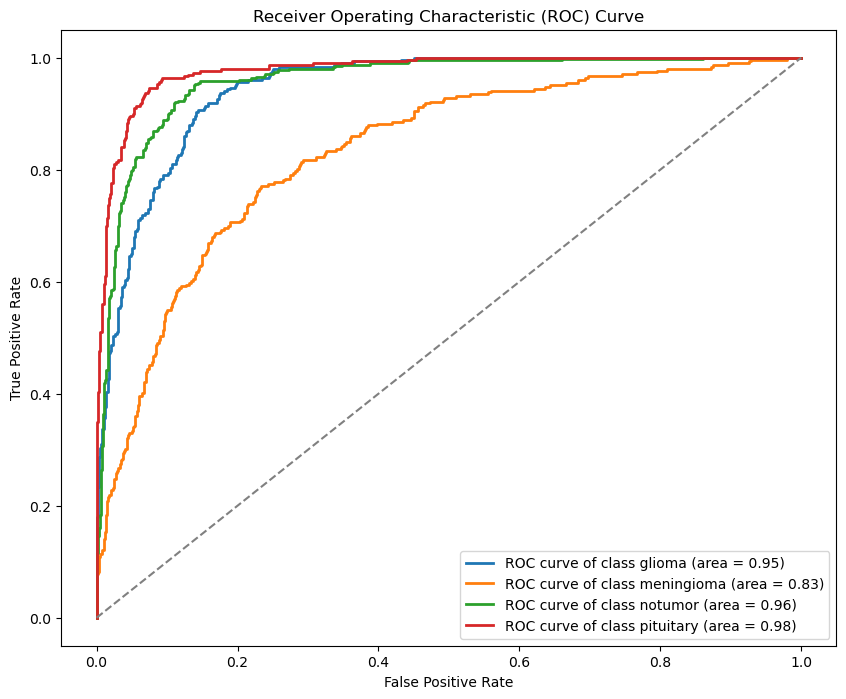

Test ROC AUC Scores: {0: 0.9455357731618859, 1: 0.83236107046467, 2: 0.9587060202218407, 3: 0.97784371909001}


In [48]:
def plot_roc_curve_test(model, data_generator, class_names):
    """
    Plots the ROC curve for a given dataset using a data generator.

    Parameters:
    - model: Trained model used to predict the dataset.
    - data_generator: Data generator that yields batches of data.
    - class_names: List of class names for labeling the ROC curve plot.
    """
    # Initialize lists to store predictions and true labels
    y_true = []
    y_pred = []
    
    # Iterate over data batches
    for x_batch, y_batch in data_generator:
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred_batch = model.predict(x_batch)
        y_pred.extend(y_pred_batch)
        
        # Stop after processing the entire dataset
        if len(y_true) >= data_generator.samples:
            break

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Binarize the output for multi-class ROC curve
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    y_pred_bin = y_pred
    
    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for i, class_name in enumerate(class_names):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {} (area = {:.2f})'.format(class_name, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='best')
    plt.show()
    
    return roc_auc

# Example usage for test dataset
class_names = list(test_data.class_indices.keys())
roc_auc_test = plot_roc_curve_test(base, test_data, class_names)
print("Test ROC AUC Scores:", roc_auc_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


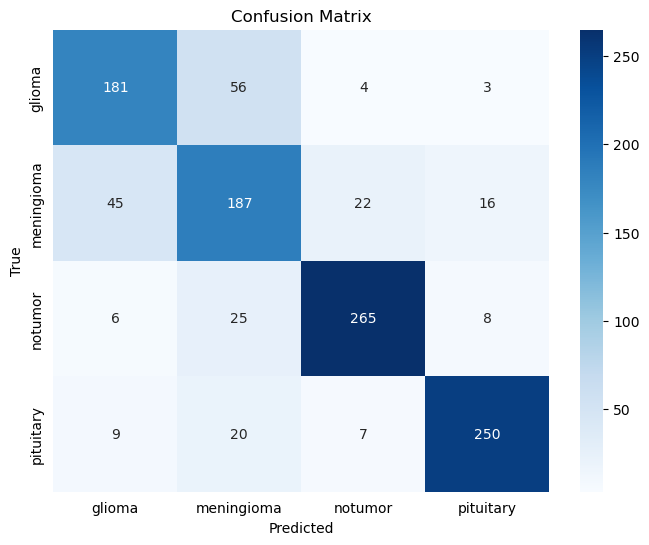

In [40]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_val(model, X, y, class_names, normalize=False):
    """
    Generates and plots the confusion matrix.
    
    Parameters:
    - model: Trained model used to predict the dataset.
    - X: Feature data (validation or test set).
    - y: True labels for the dataset.
    - class_names: List of class names for labeling the confusion matrix.
    - normalize: If True, normalize the confusion matrix by dividing by the sum of rows.
    """
    # Get model predictions
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    
    # Normalize confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
    
    # Customize the plot
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Example of usage validation dataset
class_names = list(train_data.class_indices.keys())
plot_confusion_matrix_val(base, X_val, y_val, class_names, normalize=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━

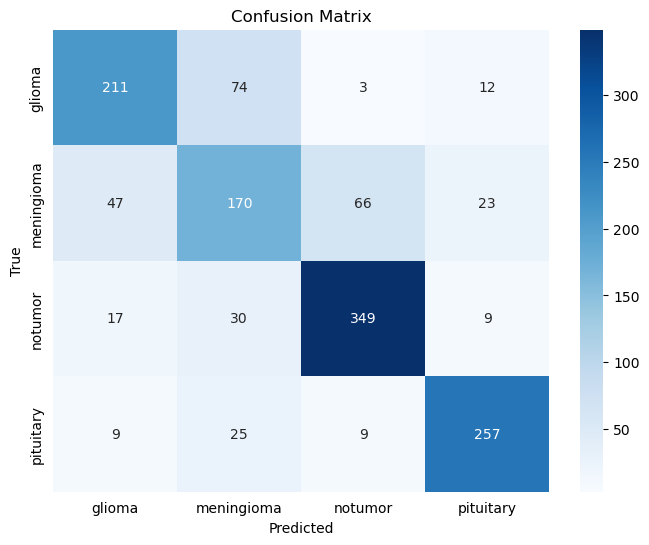

In [38]:
def plot_confusion_matrix_test(model, data_generator, class_names, normalize=False):
    """
    Generates and plots the confusion matrix for a given dataset.
    
    Parameters:
    - model: Trained model used to predict the dataset.
    - data_generator: Data generator that yields batches of data.
    - class_names: List of class names for labeling the confusion matrix.
    - normalize: If True, normalize the confusion matrix by dividing by the sum of rows.
    """
    # Initialize lists to store predictions and true labels
    y_true = []
    y_pred = []
    
    # Iterate over data batches
    for x_batch, y_batch in data_generator:
        y_true.extend(np.argmax(y_batch, axis=1))
        y_pred_batch = model.predict(x_batch)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))
        
        # Stop after processing the entire dataset
        if len(y_true) >= data_generator.samples:
            break
    
    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize confusion matrix if specified
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
    
    # Customize the plot to remove black stripes and adjust appearance
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Example for test set
class_names = list(train_data.class_indices.keys())
plot_confusion_matrix_test(base, test_data, class_names, normalize=False)

# 5. Model training

# 6. Model evaluation